# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processed from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [14]:
import os

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd

import rioxarray as rioxr

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [15]:
# Import NIR TIF file
# Make sure this is the PATH TO THE DATA FOLDER CONTAINING THE RASTERS
# Import NIR TIF file
fp = os.path.join('data','NAIP_SB_nir.tif')
nir = rioxr.open_rasterio(fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [16]:
print('Shape: ', nir.shape)
print('Data type: ', nir.dtype, '\n')

Shape:  (1, 3208, 2419)
Data type:  uint8 



In [17]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

In [18]:
print("Sizes of dimensions:", dict(nir.sizes))

Sizes of dimensions: {'band': 1, 'y': 3208, 'x': 2419}


In [19]:
# Original dimensions and coordinates
print(nir.dims, nir.coords,'\n')

# Remove length 1 dimension (band)
nir = nir.squeeze()
print(nir.dims, nir.coords,'\n')

# Remove coordinates associated to band
nir = nir.drop('band')
print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


/tmp/ipykernel_2577427/3447428643.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  nir = nir.drop('band')


In [20]:
# Examine raster attributes using rio accessor
print('Number of bands: ', nir.rio.count)
print('Height: ', nir.rio.height)
print('Width: ', nir.rio.width, '\n')

print('Spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('CRS: ', nir.rio.crs)

Number of bands:  1
Height:  3208
Width:  2419 

Spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS:  EPSG:26911


In [21]:
# Import RGB raster
fp = os.path.join('data','NAIP_SB_rgb.tif')
rgb = rioxr.open_rasterio(fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

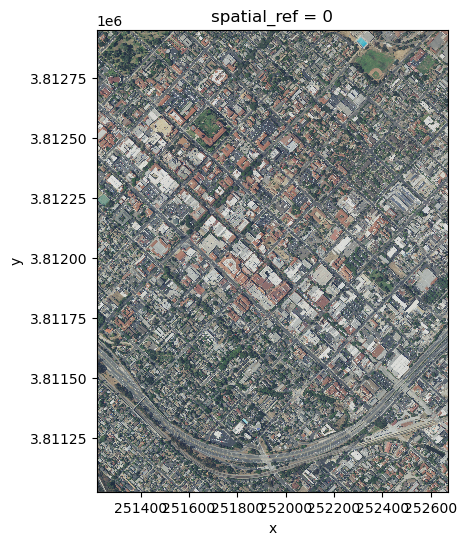

In [22]:
# Plot three bands as RGB image
rgb_aspect_ratio = rgb.rio.width / rgb.rio.height  # Raster's aspect ratio
rgb.plot.imshow(size=6,  # Plot's height in inches
                aspect=rgb_aspect_ratio  # Ratio of width/height
                )

<Axes: >

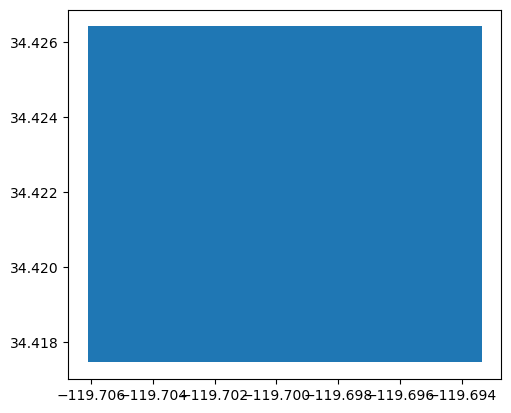

In [23]:
fp = os.path.join('data', 'SB_aoi.geojson')
aoi = gpd.read_file(fp)
aoi.plot()

In [24]:
# Examine CRss
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

aoi CRS:  EPSG:4326
nir CRS:  EPSG:26911
rgb CRS:  EPSG:26911


In [25]:
# Reproject AOI to RGB CRS
aoi = aoi.to_crs(rgb.rio.crs)
print('Matched CRS?',  aoi.crs == rgb.rio.crs)

Matched CRS? True


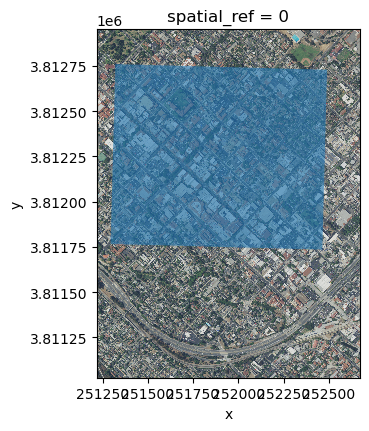

In [26]:
# Plot of RGB raster with AOI overlay
fig, ax = plt.subplots(figsize=(6, 6 * rgb_aspect_ratio))  # Directly set size and aspect
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)
plt.show()

In [27]:
# Clip rasters to AOI
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

Original shape:  (3208, 2419)
Clipped shape:  (1710, 1995)


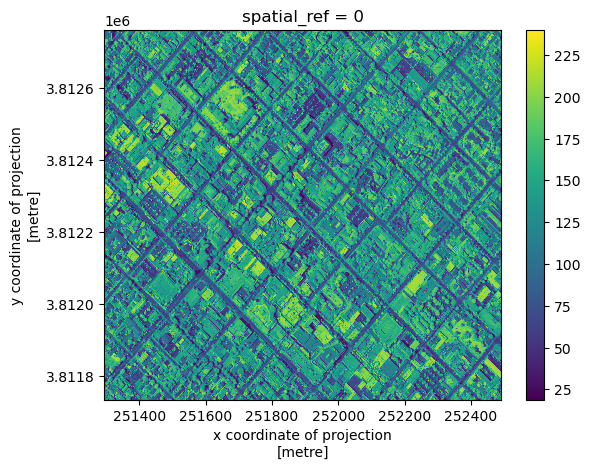

In [28]:
# Examine clipped data 
print('Original shape: ', nir.shape)
print('Clipped shape: ', nir_small.shape)

nir_small.plot()

In [29]:
# Select dimension by name and coordinate by label
red = rgb_small.sel(band=1)
red

<xarray.DataArray (y: 1710, x: 1995)> Size: 3MB
[3411450 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

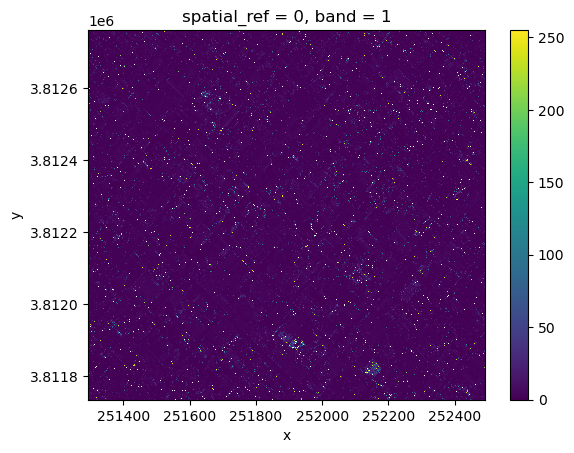

In [30]:
ndvi = (nir - red)/(nir + red)
ndvi.plot()

In [31]:
np.uint8(150) + np.uint8(150)

/tmp/ipykernel_2577427/1890984988.py:1: RuntimeWarning: overflow encountered in scalar add
  np.uint8(150) + np.uint8(150)


44

RED: original dtype: uint8 .... converted dtype: int16
NIR: original dtype: uint8 .... converted dtype: int16


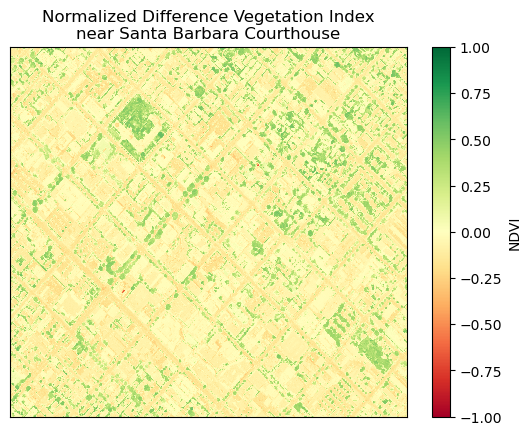

In [32]:
# Update data type to int16 to perform NDVI calculation
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

print('RED: original dtype:', rgb_small.dtype, '.... converted dtype:', red16.dtype)
print('NIR: original dtype:', nir.dtype, '.... converted dtype:', nir16.dtype)

# Calculate NDVI
ndvi = (nir16 - red16)/(nir16+red16)

# Plot
fig, ax = plt.subplots()  # Adjust figure size
ndvi.plot(
    ax=ax,
    cmap="RdYlGn",  # Colormap for NDVI
    vmin=-1,  # Minimum value
    vmax=1,   # Maximum value
    cbar_kwargs={"label": "NDVI"}  # Label for color bar
)
ax.set_title("Normalized Difference Vegetation Index\nnear Santa Barbara Courthouse")  # Add title

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

plt.show()